Stock prediction model: the goal is to create a predictive algorithim that can predict next days prices using the data from the last week's worth of close prices. Over time I shifted emphasis to accurately being able to predict trends of the market and the direction the stock is expected to go.

In [ ]:
#libraries used
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import requests
import datetime as dt
import pandas as pd

Reg models and graphing

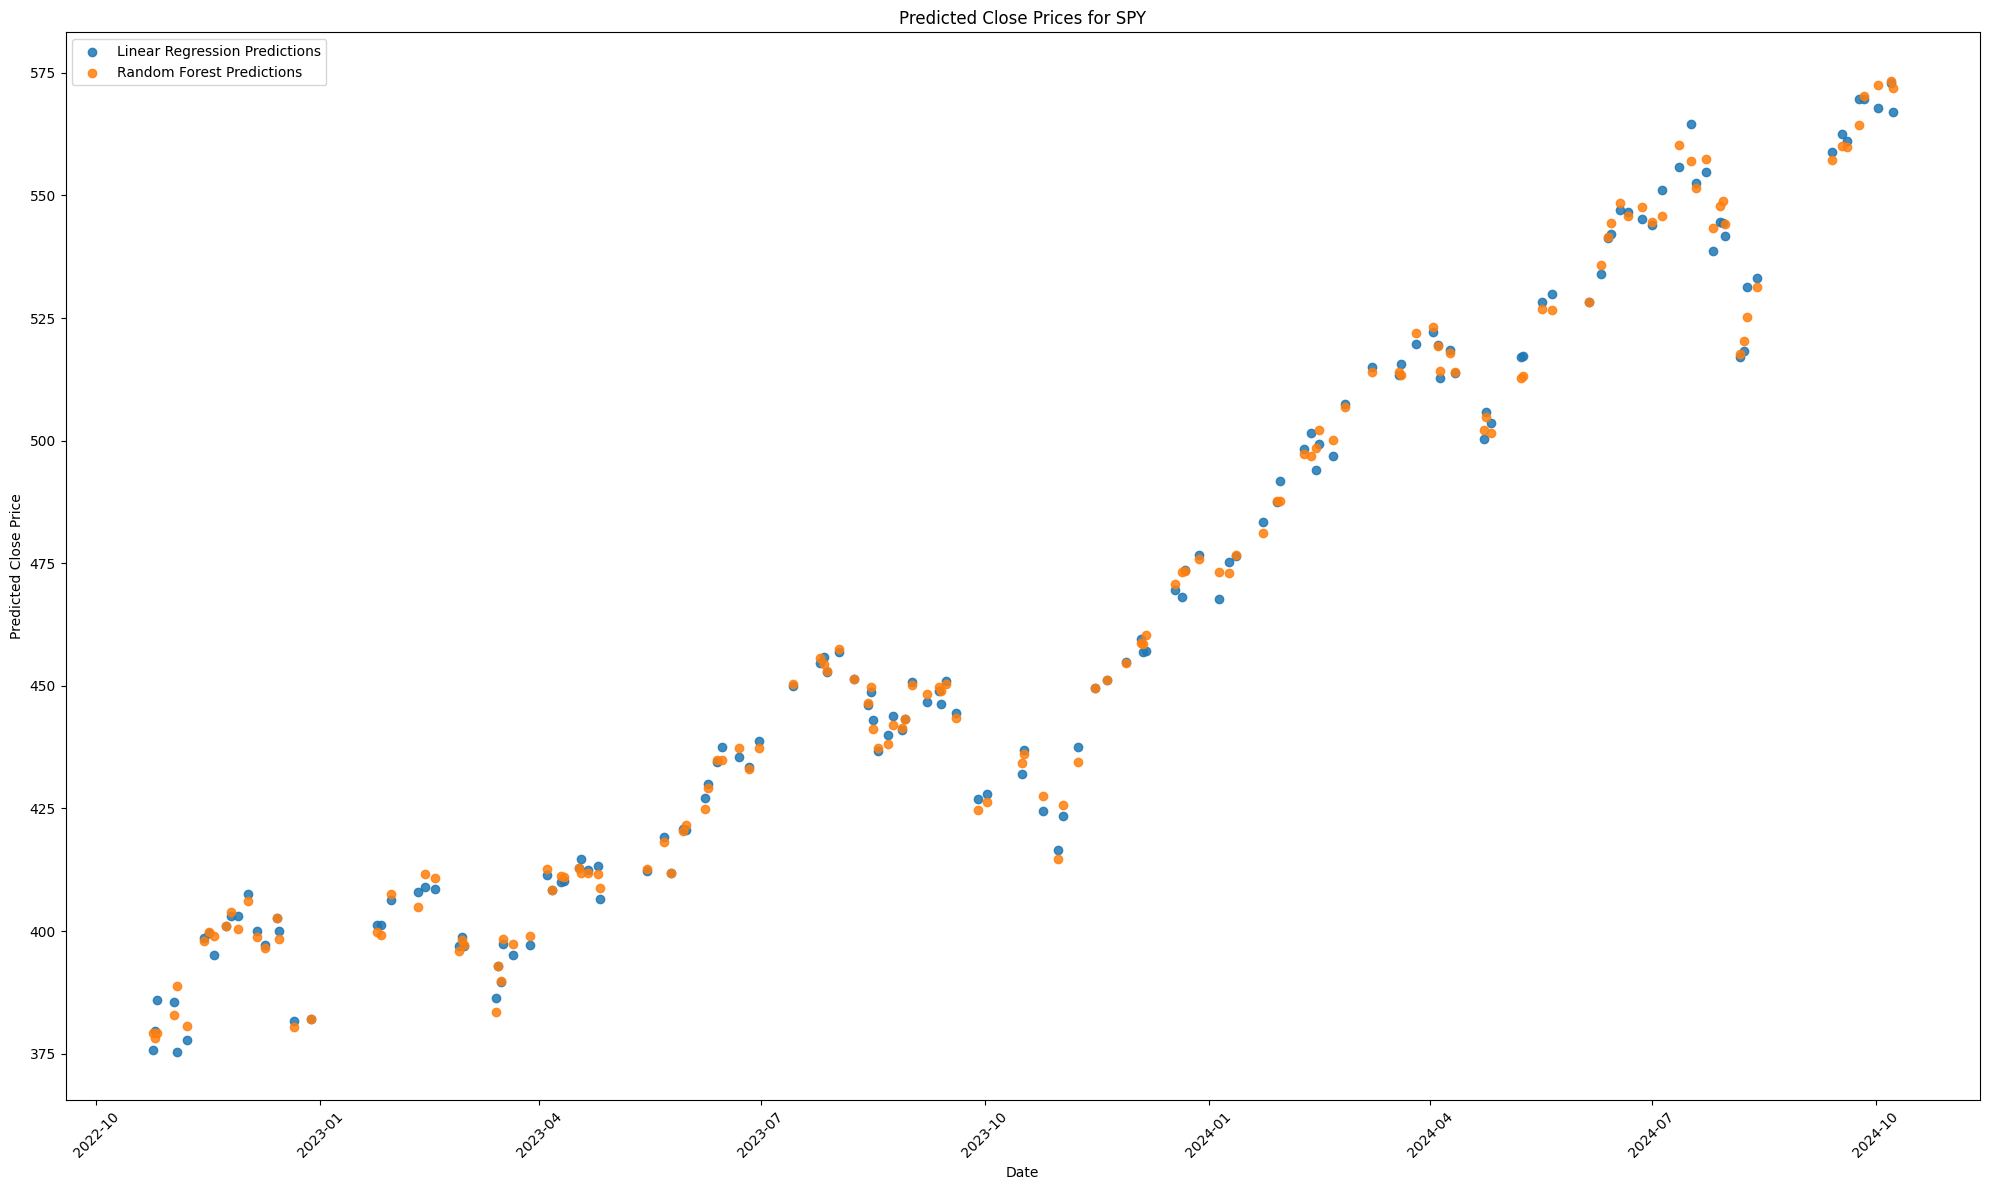

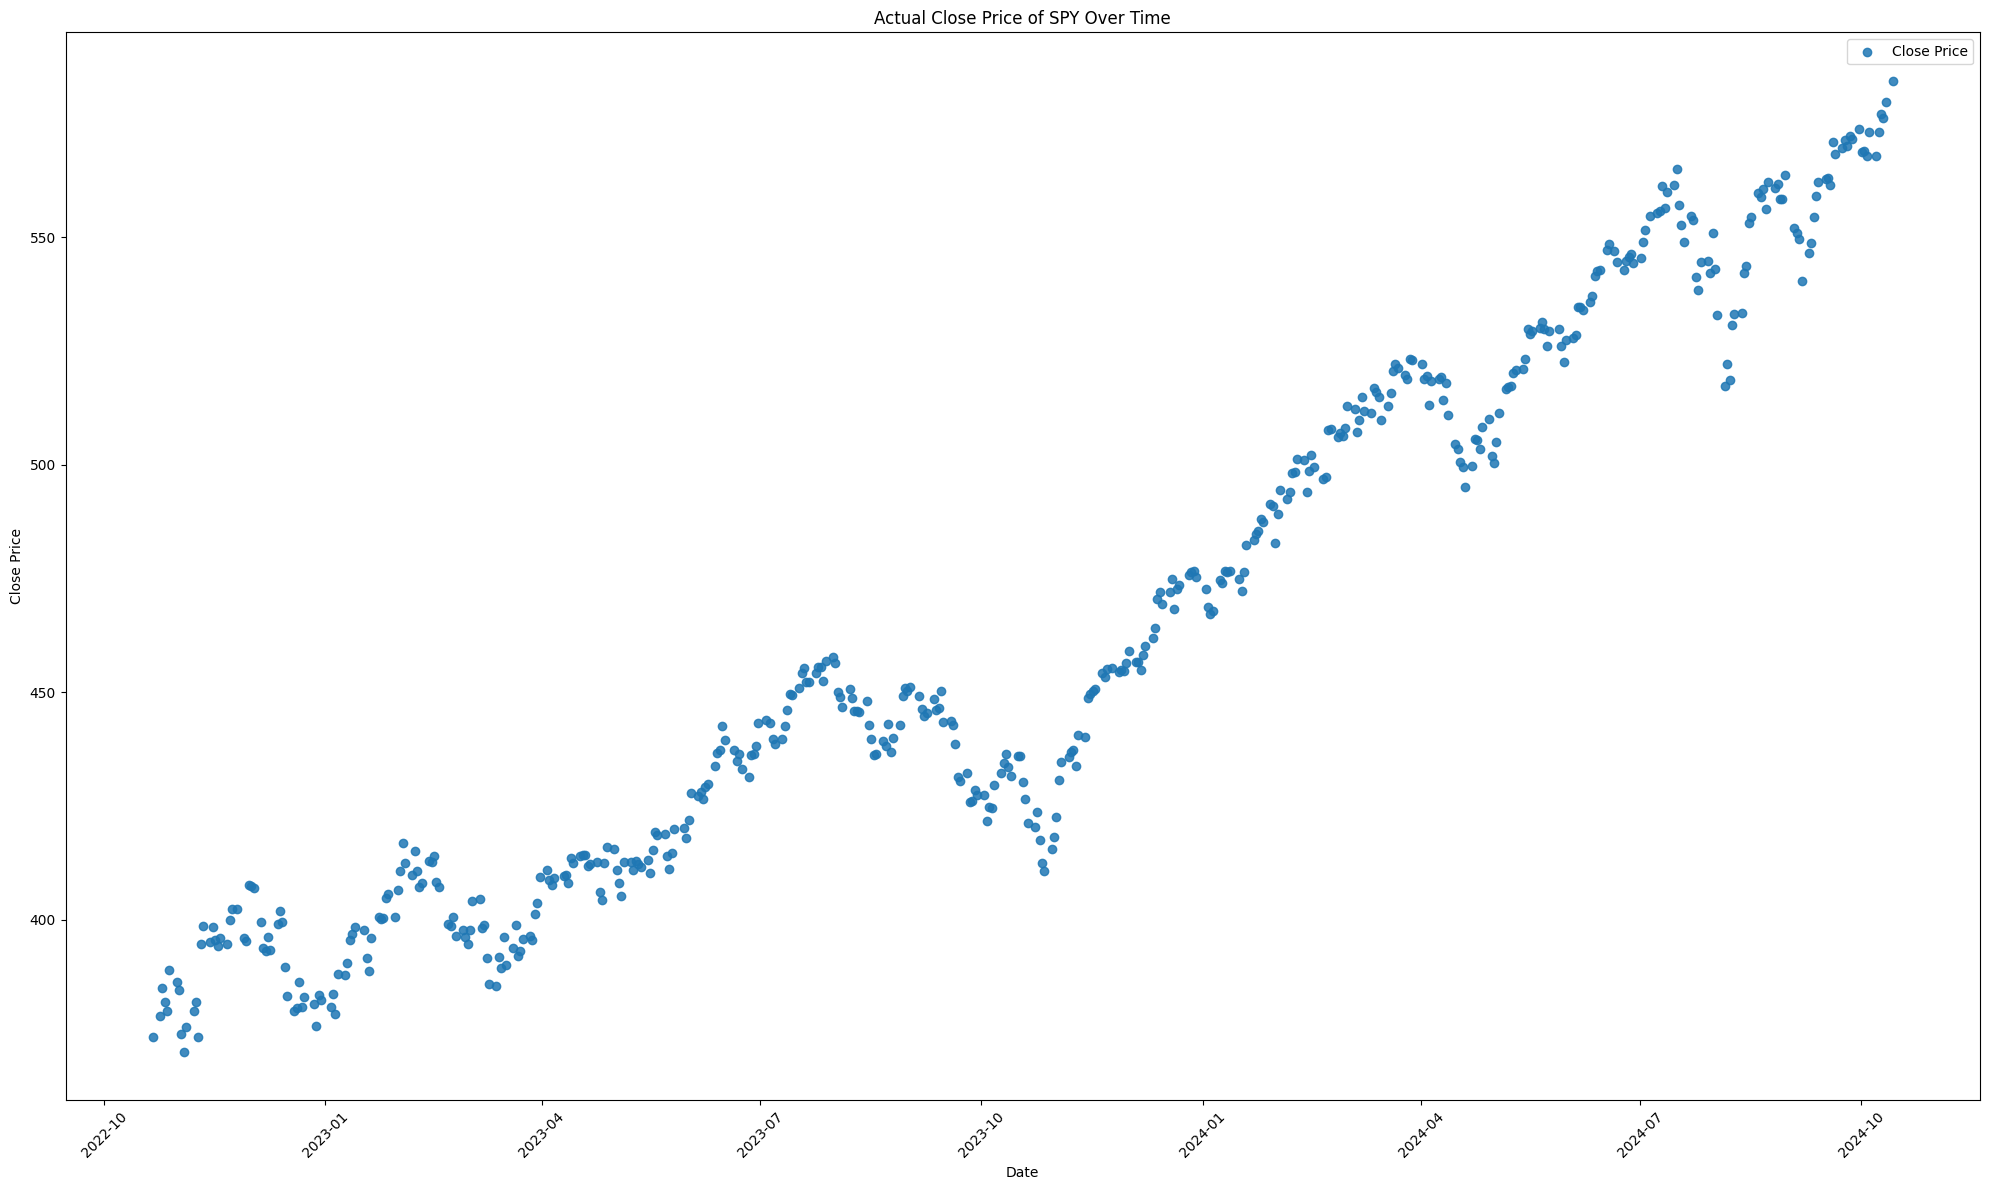

In [ ]:
#api key - my key only gives me 2 years worth of historical data
key = 'CPbnNd21WpJizO2BdPwD50RPPe3vJlxr'

#todays date
today = dt.date.today()
#todays date 2 years ago
twoyrstart = today - dt.timedelta(days=730)

#stock parameters - my api key access only gives me 2 yrs of historical stock data from today
stock = 'SPY'
start = twoyrstart
end = today

#data fetching through f-string url
url = f"https://api.polygon.io/v2/aggs/ticker/{stock}/range/1/day/{start}/{end}?apiKey={key}"
request = requests.get(url)
stock_data = request.json()['results']

#storing and sorting
data = pd.DataFrame({'date': pd.to_datetime([entry['t'] for entry in stock_data], unit='ms'),
                     'close_price': [entry['c'] for entry in stock_data]})
data.set_index('date', inplace=True)
data['previous_close_1'] = data['close_price'].shift(1)
data['previous_close_2'] = data['close_price'].shift(2)
data['previous_close_3'] = data['close_price'].shift(3)
data['previous_close_4'] = data['close_price'].shift(4)
data.dropna(inplace=True)

#assinging values
x = data[['previous_close_1', 'previous_close_2', 'previous_close_3', 'previous_close_4']]
y = data['close_price']


#ml data setup
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

#reg models and training
linear_reg_model = LinearRegression()
linear_reg_model.fit(x_train, y_train)
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, y_train)

#predictions models
linear_reg_predictions = linear_reg_model.predict(x_test)
random_forest_predictions = random_forest_model.predict(x_test)

#prediction graphing
plt.figure(figsize=(20, 12))
plt.scatter(y_test.index, linear_reg_predictions, label='Linear Regression Predictions', alpha=0.85)
plt.scatter(y_test.index, random_forest_predictions, label='Random Forest Predictions', alpha=0.85)
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.title(f'Predicted Close Prices for {stock}')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#graphing actual closing price
plt.figure(figsize=(20, 12))
plt.scatter(data.index, data['close_price'], label='Close Price', alpha=0.85)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'Actual Close Price of {stock} Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



Next day prediction and real stock price

In [ ]:
#next day date
next_day_date = data.index[-1] + pd.DateOffset(1)
print("Date of the predicted value is:", next_day_date)

#Get the last 4 days' closing prices
last_4_days = data['close_price'][-4:].values.reshape(1, -1)

#prediction using the RandomForestRegressor
next_day_prediction_rf = random_forest_model.predict(last_4_days)

#prediction using the LinearRegression
next_day_prediction_lr = linear_reg_model.predict(last_4_days)

#print
print(f"RandomForestRegressor Prediction for the {next_day_date} closing price:", next_day_prediction_rf[0])
print(f"LinearRegression Prediction for the {next_day_date} closing price:", next_day_prediction_lr[0])

#stock price today
today_real_price = data['close_price'].iloc[-1]
print(f'todays real {stock} stock price is {today_real_price}')

Date of the predicted value is: 2024-10-15 04:00:00
RandomForestRegressor Prediction for the 2024-10-15 04:00:00 closing price: 579.6343999999997
LinearRegression Prediction for the 2024-10-15 04:00:00 closing price: 576.954366801859
todays real SPY stock price is 584.32


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Accuracry metrics

In [ ]:
#linear regression model
linear_reg_mse = mean_squared_error(y_test, linear_reg_predictions)
linear_reg_rmse = np.sqrt(linear_reg_mse)
linear_reg_r2 = r2_score(y_test, linear_reg_predictions)
linear_reg_mae = mean_absolute_error(y_test, linear_reg_predictions)

#randomforest model
random_forest_mse = mean_squared_error(y_test, random_forest_predictions)
random_forest_rmse = np.sqrt(random_forest_mse)
random_forest_r2 = r2_score(y_test, random_forest_predictions)
random_forest_mae = mean_absolute_error(y_test, random_forest_predictions)

#accurary metrics
print("Linear Regression:")
print("MSE:", linear_reg_mse)
print("RMSE:", linear_reg_rmse)
print("R-squared:", linear_reg_r2)
print("MAE:", linear_reg_mae)
print("\nRandom Forest:")
print("MSE:", random_forest_mse)
print("RMSE:", random_forest_rmse)
print("R-squared:", random_forest_r2)
print("MAE:", random_forest_mae)

Linear Regression:
MSE: 15.518296354766214
RMSE: 3.9393268910774863
R-squared: 0.9954559100774476
MAE: 3.0078724523613287

Random Forest:
MSE: 19.9236581368667
RMSE: 4.463592514653046
R-squared: 0.9941659256860171
MAE: 3.439123333333367


In [ ]:
#dataframe to store actual and predicted values
comparison_df = pd.DataFrame({'Actual': y_test,
                               'Linear Regression Prediction': linear_reg_predictions,
                               'Random Forest Prediction': random_forest_predictions},
                              index=y_test.index)

#difference between actual and predicted values
comparison_df['Linear Regression Difference'] = comparison_df['Actual'] - comparison_df['Linear Regression Prediction']
comparison_df['Random Forest Difference'] = comparison_df['Actual'] - comparison_df['Random Forest Prediction']

#comparison dataframe
print(comparison_df)

                     Actual  Linear Regression Prediction  \
date                                                        
2023-09-12 04:00:00  445.99                    449.030566   
2023-03-01 05:00:00  394.74                    396.926121   
2024-02-21 05:00:00  497.21                    496.909645   
2023-04-18 04:00:00  414.21                    414.783717   
2022-12-21 05:00:00  386.23                    381.615621   
...                     ...                           ...   
2022-11-03 04:00:00  371.01                    375.424151   
2022-11-16 05:00:00  395.45                    399.634216   
2024-01-29 05:00:00  491.27                    487.473306   
2024-01-12 05:00:00  476.68                    476.499785   
2022-10-26 04:00:00  382.02                    385.931870   

                     Random Forest Prediction  Linear Regression Difference  \
date                                                                          
2023-09-12 04:00:00                  449.6662   